# Simulating Background ELG Redshifts

## Imports

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from astropy.table import Table, vstack, join
from astropy.io import fits

import desispec.io
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from desispec.spectra import Spectra

from desisim.templates import BGS, ELG

import redrock.templates
 
from desi_myfunctions import *

%matplotlib inline

## Functions

In [2]:
# Check if the outfile exists and if not run the input command

def chkfile(cmd, outfile, overwrite=False):
    
    if os.path.exists(outfile) == True and overwrite == False:
        
        return None
    
    elif os.path.exists(outfile) == True and overwrite == True:
        
        !$cmd
    
    else:
        
        !$cmd

In [3]:
# Find second magnitude based on flux ratio and first magnitude        
        
def maggen(mag, fratio=1):
    
    newmag = -2.5*np.log10(fratio)+mag
    
    return newmag

In [4]:
# Simulate and combine an ELG and BGS spectra based on given seeds and red shifts

def combspec(ELGmag, BGSmag, ELGseed, BGSseed, ELGrShifts=None, BGSrShifts=None, nrShifts=None, returnmeta=False):
    
    BGSmags = []
    ELGmags = []
    i = 0
        
    if ELGrShifts is not None and BGSrShifts is not None:
        
        while i < len(BGSrShifts):
        
            BGSmags.append(BGSmag)
            ELGmags.append(ELGmag)
            i += 1
        
        makeBGS = BGS()
        makeELG = ELG()
        
        wave = []
        flux = []

        fluxBGS, waveBGS, metaBGS, objmetaBGS = makeBGS.make_templates(seed=BGSseed, nmodel=len(BGSrShifts), redshift=BGSrShifts, mag=BGSmags, nocolorcuts=True)
        fluxELG, waveELG, metaELG, objmetaELG = makeELG.make_templates(seed=ELGseed, nmodel=len(ELGrShifts), redshift=ELGrShifts, mag=ELGmags, nocolorcuts=True)

        wave.append(waveBGS)

        flux.append(fluxBGS + fluxELG)

        if returnmeta == True:
            return wave[0], flux[0], metaBGS, metaELG

        else:
            return wave[0], flux[0]
        
    if nrShifts is not None:
        
        while i < nrShifts:
        
            BGSmags.append(BGSmag)
            ELGmags.append(ELGmag)
            i += 1
            
        makeBGS = BGS()
        makeELG = ELG()

        fluxBGS, waveBGS, metaBGS, objmetaBGS = makeBGS.make_templates(seed=BGSseed, nmodel=nrShifts, mag=BGSmags, nocolorcuts=True)
        fluxELG, waveELG, metaELG, objmetaELG = makeELG.make_templates(seed=ELGseed, nmodel=nrShifts, mag=ELGmags, nocolorcuts=True)

        wave = waveBGS
        flux = fluxBGS + fluxELG

        if returnmeta == True:
            return wave, flux, metaBGS, metaELG

        else:
            return wave, flux
        
    else:
        
        print('Please provide either ELGrShifts and BGSrShifts or nrShifts')

# Redshift Determined

## Build and Combine BGS and ELG Models with specified redshift

In [25]:
fileloc = os.path.join(os.getenv('HOME'), 'learning', 'fitsfiles', 'background_elg_randomz')

BGSseed = 24
BGSmag = 20
ELGseed = 15
fratio = .015

ELGmag = maggen(BGSmag, fratio)

combwave, combflux, BGSmeta, ELGmeta = combspec(ELGmag, BGSmag, ELGseed, BGSseed, nrShifts=5, returnmeta=True)
    
writefits(fileloc, name='comb-spec-data', data=combwave, unit='Angstrom', hdrname='Wavelength', overwrite=True)
writefits(fileloc, name='comb-spec-data', data=combflux, unit='10^-17 erg/(s*cm^2*Angstrom)', hdrname='Flux', overwrite=True)
    
infile = os.path.join(fileloc, 'comb-spec-data.fits')
outfile = os.path.join(fileloc, 'comb-obsspectra')

cmd = 'quickspectra -i {} -o {} --moonsep 100 --airmass 2.0 --moonfrac .6 --exptime 100 --seeing 2.0'.format(infile, outfile)

chkfile(cmd, outfile, overwrite=False)

INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits
INFO:io.py:959:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/elg_templates_v2.2.fits


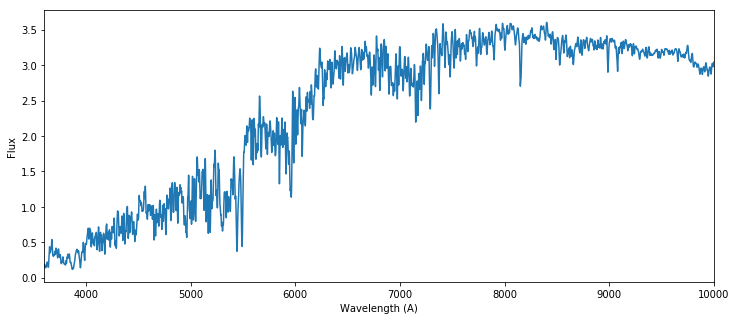

In [6]:
# Plot the combined data
i = 2

plotspec(nspec=1, wave=combwave, flux=combflux[i])

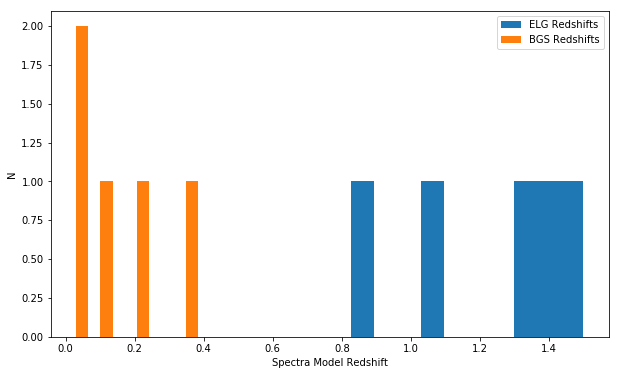

In [17]:
BGSrshifts = BGSmeta['REDSHIFT']
ELGrshifts = ELGmeta['REDSHIFT']

fig, ax = plt.subplots(1,1,figsize=(10,6))

ax.hist(ELGrshifts, label='ELG Redshifts')
ax.hist(BGSrshifts, label='BGS Redshifts')
ax.set_xlabel('Spectra Model Redshift')
ax.set_ylabel('N')
ax.legend()

## Find Best Redshift and Redrock Models with given redshift

In [19]:
rroutfile = os.path.join(fileloc, 'rr-comb-data')
rrh5file = os.path.join(fileloc, 'rr-comb-outfile.h5')

cmd = 'rrdesi {} -o {} -z {}'.format(outfile, rrh5file, rroutfile)

chkfile(cmd, rrh5file, overwrite=False)

zbest = Table.read(rroutfile, 'ZBEST')
    
tempfile = redrock.templates.find_templates()[0]
rrtemp = redrock.templates.Template(tempfile, wave=combwave)

tempflux = []
tempwave = []

for ii in range(len(zbest)):
    ncoeff = rrtemp.flux.shape[0]
    coeff = zbest['COEFF'][ii][:ncoeff]

    tempflux.append(rrtemp.flux.T.dot(coeff))
    tempwave.append(rrtemp.wave * (1+zbest[ii]['Z']))

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


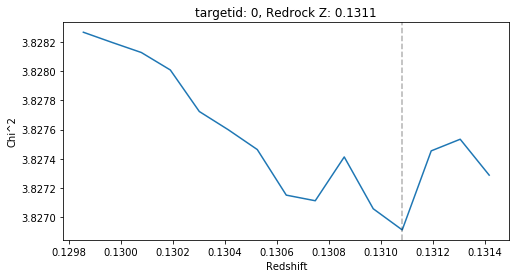

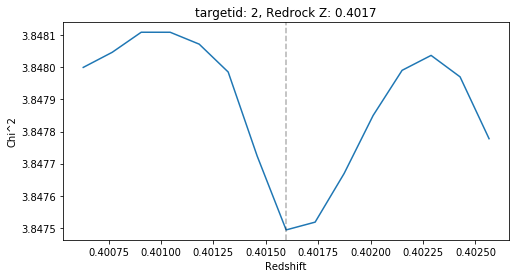

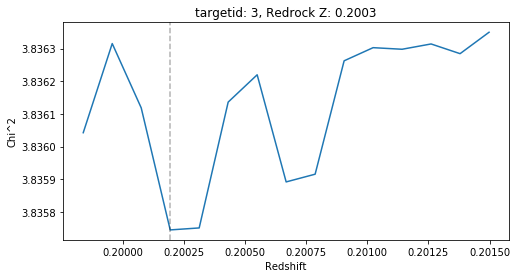

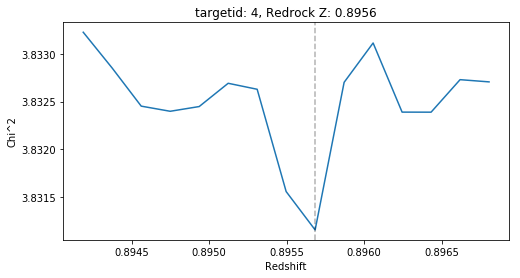

In [26]:
z = Table.read(rrh5file, 'zbest')

for i in range(len(z)):

    if np.abs(BGSmeta['REDSHIFT'][i] - z['z'][i]) > 0.003:
        
        fig, ax = plt.subplots(1,1,figsize=(8,4))
        ax.plot(z['zz'][i], np.log10(z['zzchi2'][i]))
        ax.set_xlabel('Redshift')
        ax.set_ylabel('Chi^2')
        ax.set_title('targetid: {}, Redrock Z: {:.4f}'.format(z['targetid'][i], z['z'][i]))
        
        for val in range(len(z['zzchi2'][i])):
            
            if z['zzchi2'][i][val] == np.min(z['zzchi2'][i]):
                
                ax.axvline(z['zz'][i][val], color='k', linestyle='--', alpha=0.3)

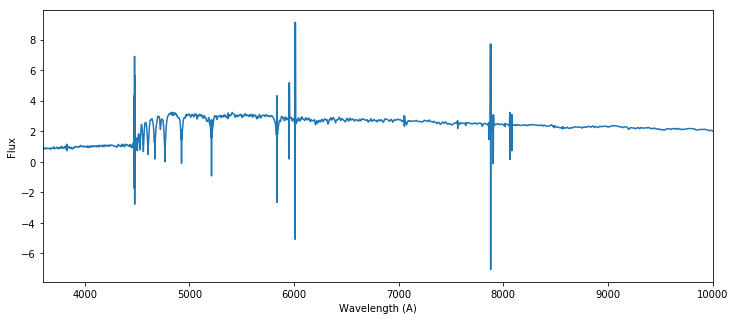

In [11]:
# Plot of BGS Redrock Template Wave and FLux
i = 3

plotspec(nspec=1, wave=tempwave[i], flux=tempflux[i])

Text(0.5,0,'Redrock Redshift')

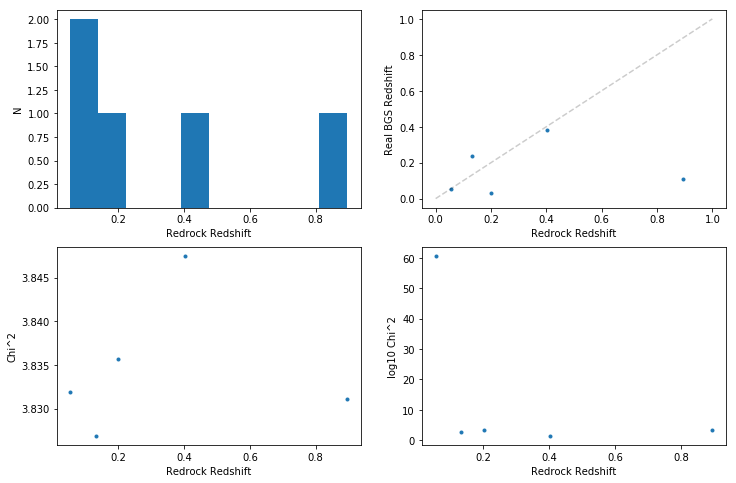

In [12]:
fig, axs = plt.subplots(2,2,figsize=(12,8)) 

ax = axs.flatten()

ax[0].hist(zbest['Z'])
ax[0].set_ylabel('N')
ax[0].set_xlabel('Redrock Redshift')

ax[1].plot(zbest['Z'], BGSrshifts, '.')
ax[1].set_ylabel('Real BGS Redshift')
ax[1].set_xlabel('Redrock Redshift')
ax[1].plot([0,1], [0,1], 'k--', alpha=0.2)

ax[2].plot(zbest['Z'], np.log10(zbest['CHI2']), '.')
ax[2].set_ylabel('Chi^2')
ax[2].set_xlabel('Redrock Redshift')

ax[3].plot(zbest['Z'], zbest['DELTACHI2'], '.')
ax[3].set_ylabel('log10 Chi^2')
ax[3].set_xlabel('Redrock Redshift')

## Find Residual and Background ELG Redshift with given redshift

In [18]:
specfiles = rrtemp_to_spectra(outfile=outfile, nrshifts=len(BGSrshifts), fileloc=fileloc, tempfluxes=tempflux, tempwaves=tempwave)

reszbests = []
resh5files = []

for filenum in range(len(specfiles)):
    
    rrsuboutfile = os.path.join(fileloc, 'rr-rerun-subtracted-{}'.format(filenum))
    rrresh5file = os.path.join(fileloc, 'rr-residual-h5-{}'.format(filenum))
    
    cmd = 'rrdesi {} -o {} -z {}'.format(specfiles[filenum], rrresh5file, rrsuboutfile)

    chkfile(cmd, rrresh5file, overwrite=False)
    
    reszbest = Table.read(rrsuboutfile, "ZBEST")
    
    reszbests.append(reszbest)
    resh5files.append(rrresh5file)
    
reszbests = vstack(reszbests)

reszbests['realz'] = ELGrshifts
reszbests['fratio'] = [.015, .015, .015, .015, .015]
reszbests['dz'] = ELGrshifts - reszbests['Z']

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits


Text(0.5,1,'Z: 0.5587607528517622, real z: 1.0675283670425415')

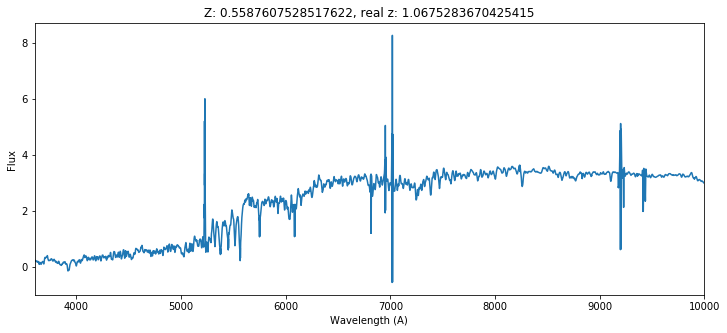

In [14]:
ELGtempfile = redrock.templates.find_templates()[0]
ELGrrtemp = redrock.templates.Template(ELGtempfile, wave=combwave)

ELGtempflux = []
ELGtempwave = []

for ii in range(len(reszbests)):
    
    nELGcoeff = ELGrrtemp.flux.shape[0]
    ELGcoeff = reszbests['COEFF'][ii][:nELGcoeff]

    ELGtempflux.append(ELGrrtemp.flux.T.dot(ELGcoeff))
    ELGtempwave.append(ELGrrtemp.wave * (1 + reszbests[ii]['Z']))

i = 2
    
plotspec(nspec=1, wave=tempwave[i], flux=tempflux[i])
plt.title('Z: {}, real z: {}'.format(reszbests['Z'][i], ELGrshifts[i]))

Text(0,0.5,'log10 Chi^2')

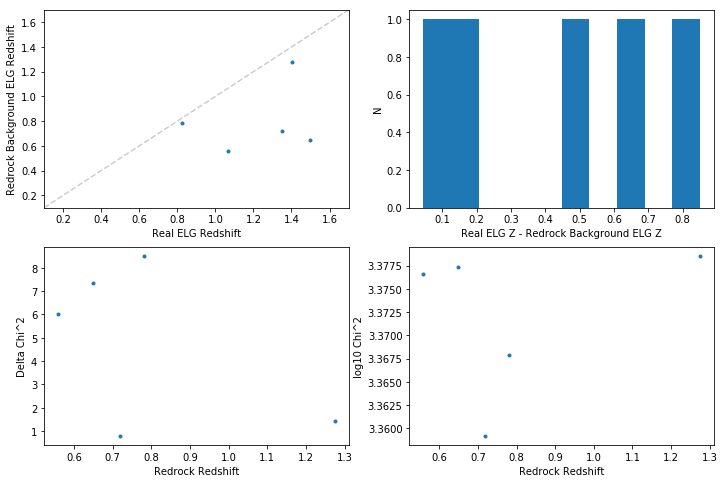

In [15]:
dlim = (0.1, 1.7)

fig, axs = plt.subplots(2,2,figsize=(12,8))

ax = axs.flatten()

ax[0].plot(ELGrshifts, reszbests['Z'], '.')
ax[0].set_xlim(dlim)
ax[0].set_ylim(dlim)
ax[0].plot([dlim[0], dlim[1]], [dlim[0], dlim[1]], 'k--', alpha=0.2)
ax[0].set_xlabel('Real ELG Redshift')
ax[0].set_ylabel('Redrock Background ELG Redshift')

ax[1].hist(reszbests['dz'])
ax[1].set_ylabel('N')
ax[1].set_xlabel('Real ELG Z - Redrock Background ELG Z')

ax[2].plot(reszbests['Z'], reszbests['DELTACHI2'], '.')
ax[2].set_xlabel('Redrock Redshift')
ax[2].set_ylabel('Delta Chi^2')

ax[3].plot(reszbests['Z'], np.log10(reszbests['CHI2']), '.')
ax[3].set_xlabel('Redrock Redshift')
ax[3].set_ylabel('log10 Chi^2')

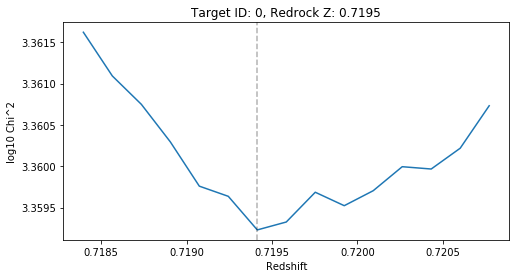

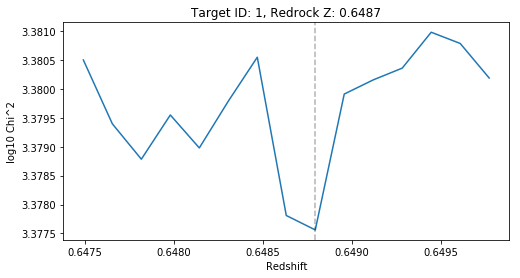

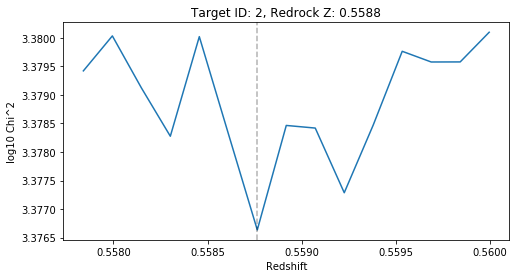

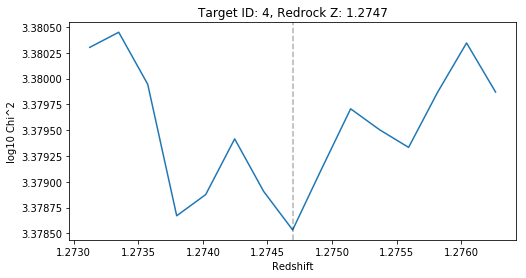

In [24]:
for i in range(len(resh5files)):

    z = Table.read(resh5files[i])
    
    if np.abs(reszbests['dz'][i]) > 0.1:
        
        fig, ax = plt.subplots(1,1,figsize=(8,4))
        ax.plot(z['zz'][0], np.log10(z['zzchi2'][0]))
        ax.set_xlabel('Redshift')
        ax.set_ylabel('log10 Chi^2')
        ax.set_title('Target ID: {}, Redrock Z: {:.4f}'.format(z['targetid'][0], z['z'][0]))
        
        for val in range(len(z['zzchi2'][0])):
            
            if z['zzchi2'][0][val] == np.min(z['zzchi2'][0]):
                
                ax.axvline(z['zz'][0][val], color='k', linestyle='--', alpha=0.3)

In [29]:
rrfail = np.where(np.abs(reszbests['dz']) > 0.1)[0]

reszbests['TARGETID', 'Z', 'dz'][rrfail]

TARGETID,Z,dz
int64,float64,float64
0,0.7194659828905196,0.6302218318220049
1,0.6487268696104608,0.8503354301179328
2,0.5587607528517622,0.5087676141907793
4,1.2746695879350975,0.12799853054177013
